## EECE5644 Assignment 4 - Question 1

#### Import Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
import pandas as pd
import seaborn as sns


np.random.seed(67)

plt.rcParams['figure.figsize'] = (10, 8)

#### Data Generation

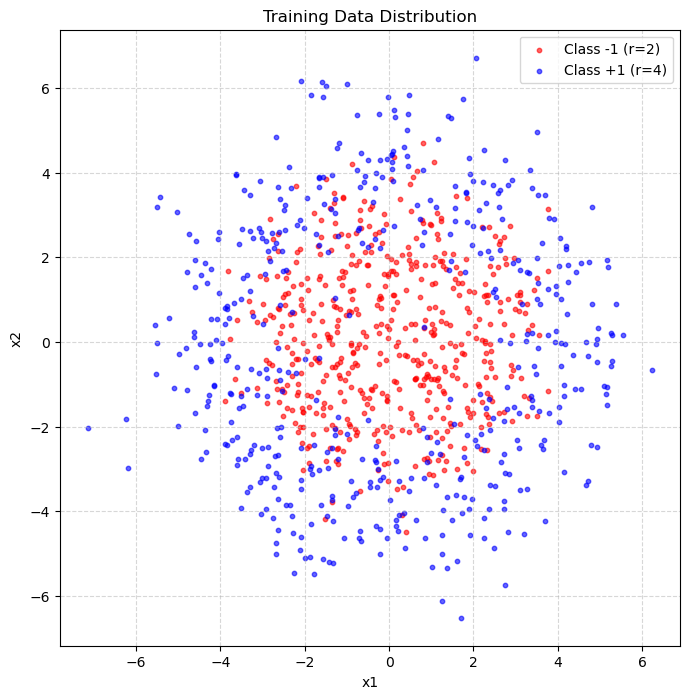

In [ ]:
def generate_data(n_samples):
    X = []
    y = []
    
    for _ in range(n_samples):
        # Assign label randomly with equal probability (iid)
        label = np.random.choice([-1, 1])
        
        # Set radius based on label
        r_true = 2 if label == -1 else 4
        
        # Theta uniformly distributed between -pi and pi 
        theta = np.random.uniform(-np.pi, np.pi)
        
        # Base coordinates on the circle
        base_x = r_true * np.cos(theta)
        base_y = r_true * np.sin(theta)
        
        noise = np.random.normal(0, 1, 2)
        
        # Feature vector
        x_vec = np.array([base_x, base_y]) + noise
        
        X.append(x_vec)
        y.append(label)
        
    return np.array(X), np.array(y)

# Generate Training Data (1000 samples) 
X_train, y_train = generate_data(1000)

# Generate Testing Data (10000 samples)
X_test, y_test = generate_data(10000)

# Visualize Training Data
plt.figure(figsize=(8, 8))
plt.scatter(X_train[y_train==-1][:, 0], X_train[y_train==-1][:, 1], 
            c='red', s=10, alpha=0.6, label='Class -1 (r=2)')
plt.scatter(X_train[y_train==1][:, 0], X_train[y_train==1][:, 1], 
            c='blue', s=10, alpha=0.6, label='Class +1 (r=4)')
plt.title("Training Data Distribution")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.axis('equal')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

#### SVM Classifier with K-Fold Cross-Validation

Starting SVM Hyperparameter tuning...
Best SVM Parameters: {'C': 1, 'gamma': 0.01}
Best SVM Validation Accuracy: 0.8280


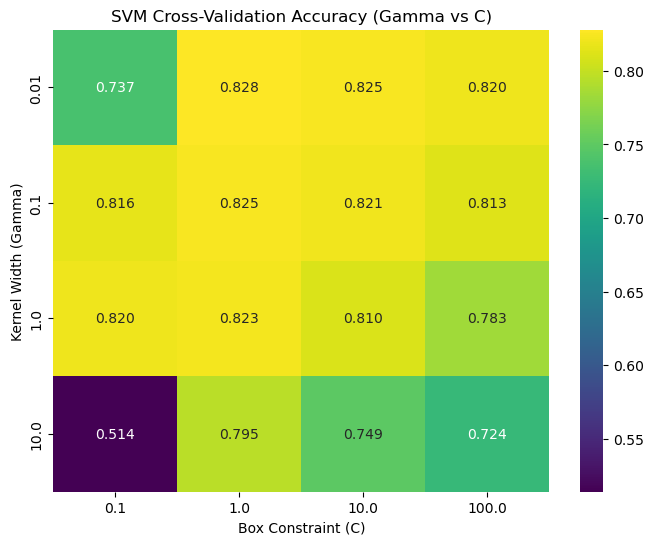

In [ ]:
print("Starting SVM Hyperparameter tuning...")

# Define parameter grid for GridSearch
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1, 10]
}

# Initialize SVM with Gaussian (RBF)
svc = SVC(kernel='rbf')

# Perform 5-Fold Cross-Validation
grid_svm = GridSearchCV(svc, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X_train, y_train)

# Output best parameters
print(f"Best SVM Parameters: {grid_svm.best_params_}")
print(f"Best SVM Validation Accuracy: {grid_svm.best_score_:.4f}")

# Visual Demonstration of CV process
results_svm = pd.DataFrame(grid_svm.cv_results_)
pivot_svm = results_svm.pivot(index='param_gamma', columns='param_C', values='mean_test_score')

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_svm, annot=True, fmt=".3f", cmap="viridis")
plt.title("SVM Cross-Validation Accuracy (Gamma vs C)")
plt.xlabel("Box Constraint (C)")
plt.ylabel("Kernel Width (Gamma)")
plt.show()

#### MLP Classifier with K-Fold Cross-Validation

Starting MLP Hyperparameter tuning...
Best MLP Parameters: {'hidden_layer_sizes': (28,)}
Best MLP Validation Accuracy: 0.8290


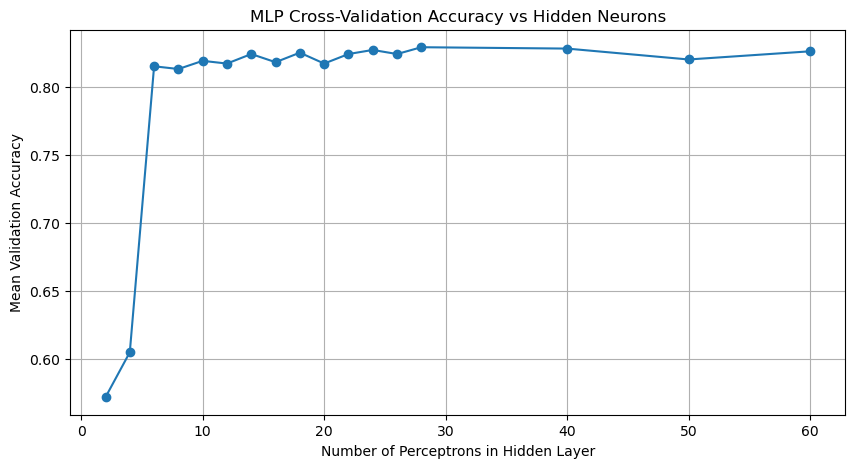

In [ ]:
print("Starting MLP Hyperparameter tuning...")

# Define parameter grid for GridSearch: Number of perceptrons in the hidden layer
neuron_counts = list(range(2, 30, 2)) + [40, 50, 60]
param_grid_mlp = {
    'hidden_layer_sizes': [(n,) for n in neuron_counts]
}

# Initialize MLP (Single hidden layer)
mlp = MLPClassifier(activation='relu', solver='adam', max_iter=3000, random_state=42)

# Perform 5-Fold Cross-Validation
grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='accuracy', n_jobs=-1)
grid_mlp.fit(X_train, y_train)

# Output best parameters
print(f"Best MLP Parameters: {grid_mlp.best_params_}")
print(f"Best MLP Validation Accuracy: {grid_mlp.best_score_:.4f}")

# Visual Demonstration of CV process
results_mlp = pd.DataFrame(grid_mlp.cv_results_)
# Extract hidden layer size (first element of tuple) for plotting
results_mlp['neurons'] = results_mlp['param_hidden_layer_sizes'].apply(lambda x: x[0])

plt.figure(figsize=(10, 5))
plt.plot(results_mlp['neurons'], results_mlp['mean_test_score'], marker='o', linestyle='-')
plt.title("MLP Cross-Validation Accuracy vs Hidden Neurons")
plt.xlabel("Number of Perceptrons in Hidden Layer")
plt.ylabel("Mean Validation Accuracy")
plt.grid(True)
plt.show()

#### Evaluation and Decision Boundaries

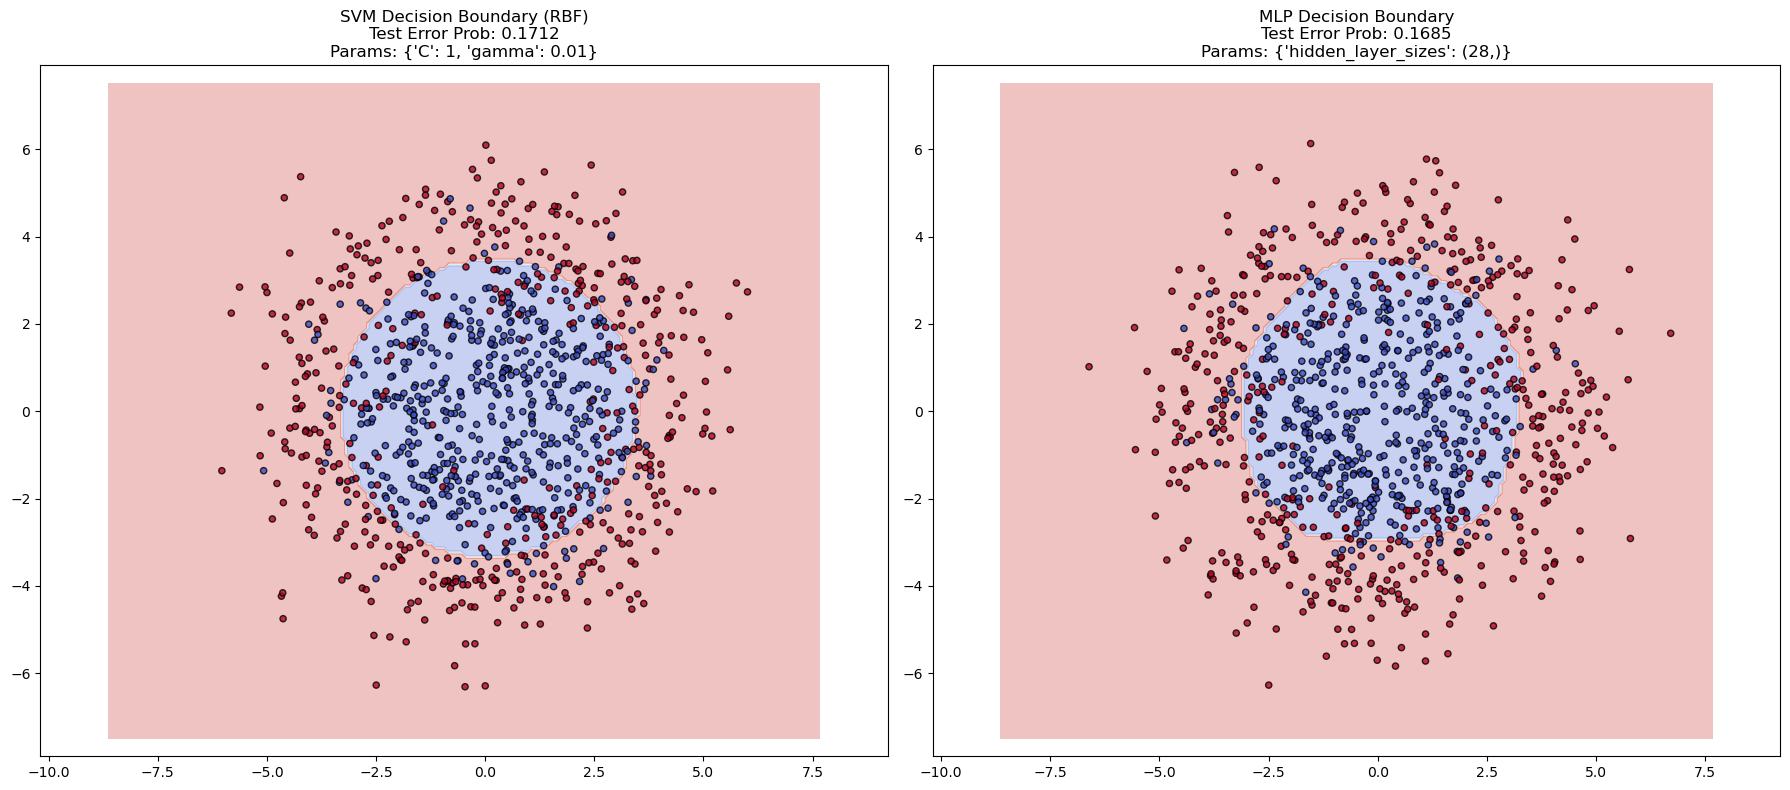

Final Performance on Test Data (10,000 samples):
--------------------------------------------------
SVM Test Error Probability: 0.1712
MLP Test Error Probability: 0.1685


In [ ]:
def plot_decision_boundary(model, X, y, title, ax):
    # Create a meshgrid
    h = .1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict class for each point in the mesh
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot contours
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.3)
    
    # Plot a subset of test data to avoid overcrowding
    subset_idx = np.random.choice(len(X), 1000, replace=False)
    ax.scatter(X[subset_idx, 0], X[subset_idx, 1], c=y[subset_idx], 
               cmap=plt.cm.coolwarm, edgecolors='k', s=20, alpha=0.8)
    ax.set_title(title)
    ax.axis('equal')


# Evaluate SVM
best_svm = grid_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)
error_svm = 1 - accuracy_score(y_test, y_pred_svm) # Probability of error

# Evaluate MLP
best_mlp = grid_mlp.best_estimator_
y_pred_mlp = best_mlp.predict(X_test)
error_mlp = 1 - accuracy_score(y_test, y_pred_mlp) # Probability of error

fig, axes = plt.subplots(1, 2, figsize=(18, 8))
# Plot SVM Result
title_svm = f"SVM Decision Boundary (RBF)\nTest Error Prob: {error_svm:.4f}\nParams: {grid_svm.best_params_}"
plot_decision_boundary(best_svm, X_test, y_test, title_svm, axes[0])

# Plot MLP Result
title_mlp = f"MLP Decision Boundary\nTest Error Prob: {error_mlp:.4f}\nParams: {grid_mlp.best_params_}"
plot_decision_boundary(best_mlp, X_test, y_test, title_mlp, axes[1])

plt.tight_layout()
plt.show()

# Print final numerical results
print("Final Performance on Test Data (10,000 samples):")
print("-" * 50)
print(f"SVM Test Error Probability: {error_svm:.4f}")
print(f"MLP Test Error Probability: {error_mlp:.4f}")